In [118]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

The functions below form the core of the simulation. Note that we haven't bothered to write a function for computing magnetization, because the magnetization is just the sum of the spins on the lattice.

In [21]:
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = (mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X])
    d_energy = 2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]

In [4]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [23]:
def mc_step(init, boltz, n, plot = False, final_only = False):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = init[:,:]
    
    for i in range(n):    
        # evolve using metropolis
        evo = metropolis_ising(grid, boltz)[0]
        
        if plot == True:
            # plotting
            if final_only == False:    
                plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')


            else:
                if i == n-1:
                    plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')
        
        # reset iteration variable
        grid = evo[:,:]
        
    return grid

In [3]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep(init, boltz):
    
    grid = init[:,:]
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [6]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

The following functions are auxiliary; they are used to check various properties of the simulation, like equilibration time or thermodynamic properties.

In [7]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [8]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag/total)
    
        # reset iteration variable
        grid = evo[:,:]

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

In [13]:
def auto_cor_m(init, boltz, n):
    """Compute the time auto-correlation value using the magnetization per spin"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    mag_list = magps(init, boltz, n, plot = False)
    
    mag_mean = np.mean(mag_list)
    m_mean2 = mag_mean**2
    
    auto_cor = []
    
    for i in range(len(mag_list)-1):
        
        auto_cor.append(mag_list[i]*mag_list[i+1] - m_mean2)
        
    # plotting
    x_axis = [i/total for i in range(len(auto_cor))]

    plt.figure(figsize=(6,6))
    plt.plot(x_axis,auto_cor)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('Sweeps', fontsize=20)
    plt.title(f'Magnetization Autocorrelation', fontsize=20)
    
    
    
    

The following function are measurements that involve means. To get accurate means, one should probably sample with a frequency no greater than once per sweep, i.e. once per N number of MC steps, where N is the number of spins on the lattice.

In [9]:
# keep in mind sampling frequency for the energies in energy_list
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at temperature T and lattice sites N"""
    
    if type(energy_list) is list:
        energy_list = np.array(energy_list)
    
    moment_1 = np.mean(energy_list)
    moment_2 = np.mean(np.square(energy_list))
    
    c = (1/(T**2 * N)) * (moment_2 - moment_1**2)
    
    return c

In [10]:
def sus(mag_list, T, N):
    """Compute susceptibility for an input list of mag per spin values at temperature T and lattice sites N"""
    
    if type(mag_list) is list:
        mag_list = np.array(mag_list)
    
    moment_1 = np.mean(mag_list)
    
    moment_2 = np.mean(np.square(mag_list))
    
    chi = (N/T) * (moment_2 - moment_1**2)
    
    return chi

In [78]:
def ss_cor(init, boltz, n_sweep, n_equil, s1, s2):
    """Compute the mean correlation between spins s1 and s2"""
    
    grid = init[:,:]
    
    cor = 0
    
    # evolve to equilibrium
    for i in range(n_equil):
        mc_sweep(grid, boltz)
        
    # set the equilibrium value after which measurements will be made
    for j in range(n_sweep):
        mc_sweep(grid, boltz)
        cor += grid[s1[0],s1[1]] * grid[s2[0],s2[1]]
    
        
    cor = cor/(n_sweep)
    
    return cor

In [11]:
# c_list is a list of specific heats per spin computed at the evenly-spaced, 
# ascending-ordered temperatures on temp_list
# s_0 is the entropy per spin at the the minimum of temp_list 
def ent_ps(temp_list, c_list, s_0):
    """Compute the entropy of an Ising lattice using the trapezoidal rule for a given set of temperatures and c"""
    
    dT = temp_list[1] - temp_list[0]
    n = len(temp_list)
    
    # compute the boundary terms
    t_min = temp_list[0]
    t_max = temp_list[-1]
    
    c_1 = c_list[0]
    c_2 = c_list[-1]
    
    boundary = (c_2/t_max + c_1/t_min)
    
    
    # initialize the integral sum
    integral = boundary
    
    for i in range(1,n-1):
        integral += c_list[i]/temp_list[i]
        
    integral = integral*dT
    
    # include the integration constant
    s = s_0 + integral
    
    return s
    

Below is some code used to explore the temperature range around the critical temperature, as well as a rudimentary attempt to obtain a value for the critical temperature and critcal exponents.

In [80]:
# exploring the temperature range around the critical temp

t_crit = 2.269
temps = np.random.normal(t_crit, 0.68, 250)      # want finer temperature resolution around the critical temperature
temps = [t for t in temps if (t > 1.0) & (t<3.5)]      # take out fringes
t_points = len(temps)

# initialize lists
eneps = np.zeros(t_points)
magps = np.zeros(t_points)
spec_heat = np.zeros(t_points)
mag_sus = np.zeros(t_points)

In [81]:
# initialize to T = 0
test = 1*np.ones((15,15))      # large lattices and equilibration times strongly correlate to total runtime
init = test[:,:]

# rough estimate for equilibration time; 5*N many sweeps
n_eq = 5*15**2

# number of sweeps to average over
n = 1000

# factors for averaging
n1 = 1/(n * 15**2)
n2 = 1/(n**2 * 15**2)

In [82]:
start = time.time()

grid = copy.copy(init)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy               # faster than squaring using **2 I think?
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps[i] = n1*e_total
    magps[i] = n1*mag_total
    spec_heat[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)    

466.6361334323883


Text(0,0.5,'Susceptibility')

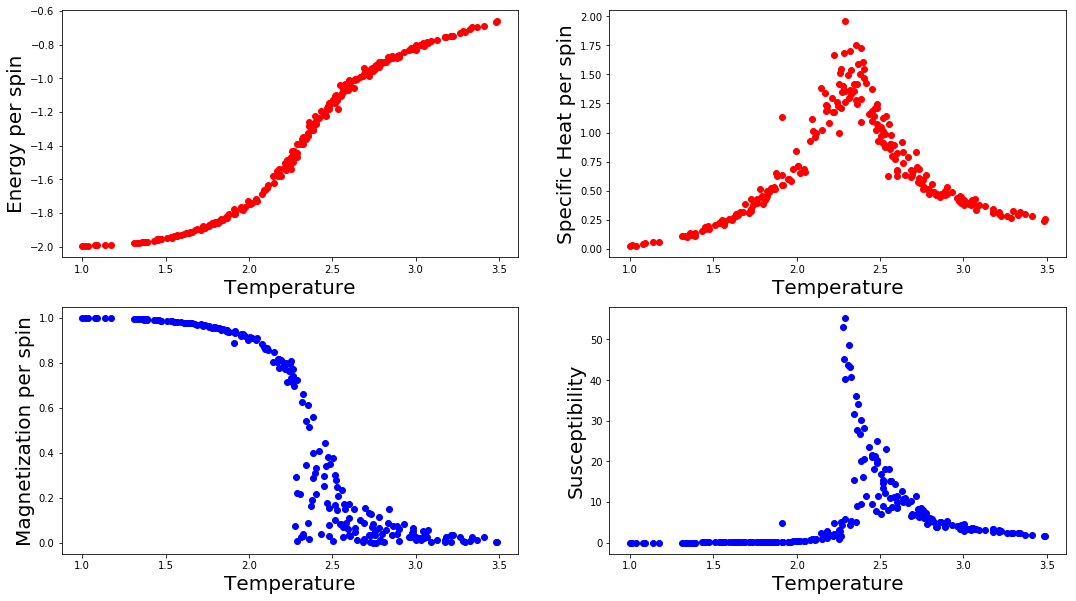

In [211]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [94]:
eneps15 = open("eneps15.npy", "w+")
np.save("eneps15.npy", eneps)

In [98]:
magps15 = open("magps15.npy", "w+")
spec_heat15 = open("spec_heat15.npy", "w+")
mag_sus15 = open("mag_sus15.npy", "w+")

In [99]:
np.save("magps15.npy", magps)
np.save("spec_heat15.npy", spec_heat)
np.save("mag_sus15.npy", mag_sus)

Although our grid is relatively small (15 $\times$ 15), we are still able to extract some good information because each average is computed from 1000 values.

In [110]:
# roughly approximating the critical temperature by just looking at the peaks of specific heat and susceptibility
ci_max = np.argmax(spec_heat)
si_max = np.argmax(mag_sus)

(temps[ci_max] + temps[si_max])/2

2.288354027642459

The downside of so many temperature points is that it is hard to fit a curve to the data using standard techniques. We repeat the process for fewer temperature points, but increasing the size of the lattice to compensate.

In [114]:
# exploring the temperature range around the critical temp

t_crit = 2.269
temps30 = [i for i in np.arange(1, 3.5, 0.1)]
t_points30 = len(temps30)

# initialize lists
eneps30 = np.zeros(t_points30)
magps30 = np.zeros(t_points30)
spec_heat30 = np.zeros(t_points30)
mag_sus30 = np.zeros(t_points30)

# initialize to T = 0
test = 1*np.ones((30,30))      
init = test[:,:]

# rough estimate for equilibration time; 5*N many sweeps
n_eq = 5*30**2

# number of sweeps to average over
n = 1000

# factors for averaging
n1 = 1/(n * 30**2)
n2 = 1/(n**2 * 30**2)

start = time.time()

grid = copy.copy(init)

for i in range(t_points30):
    T = temps30[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps30[i] = n1*e_total
    magps30[i] = n1*mag_total
    spec_heat30[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus30[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)

485.99698972702026


Text(0,0.5,'Susceptibility')

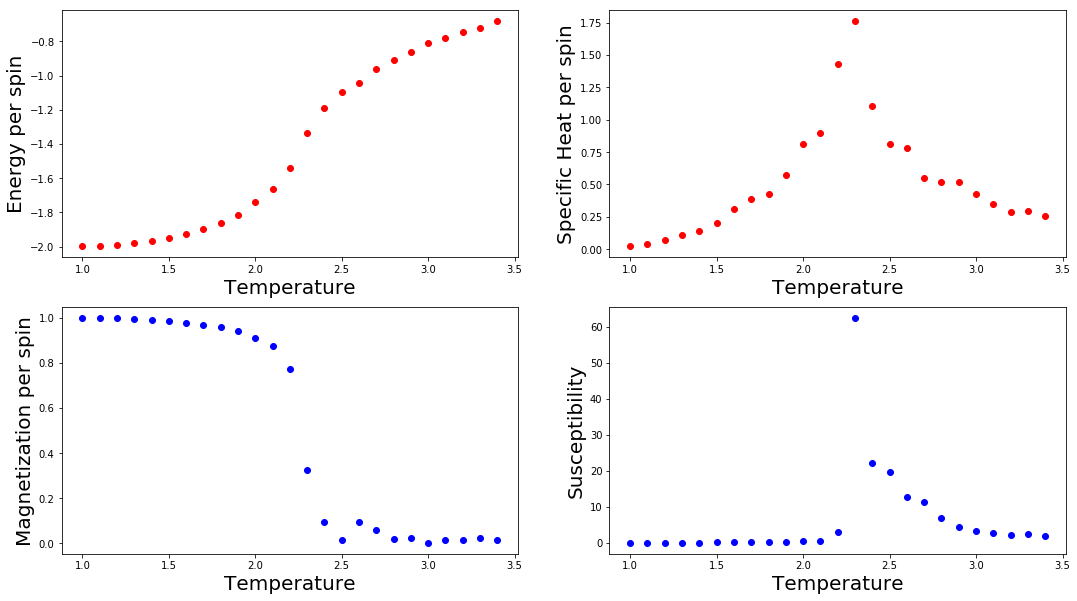

In [212]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps30, eneps30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps30, spec_heat30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps30, abs(magps30), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps30, mag_sus30, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [173]:
red_temp = [(t_crit-t)/t_crit for t in temps30]

red_temp[0:13]

[0.5592772146319965,
 0.5152049360951961,
 0.47113265755839573,
 0.4270603790215953,
 0.3829881004847949,
 0.3389158219479946,
 0.2948435434111942,
 0.2507712648743938,
 0.2066989863375934,
 0.162626707800793,
 0.11855442926399261,
 0.07448215072719222,
 0.03040987219039183]

In [206]:
log_mag = np.log(np.array(abs(magps30)[10:13]))

In [208]:
log_mag

array([-0.09467949, -0.13250081, -0.2550557 ])

In [168]:
def f(x, a, b):
    return a*x + b

In [194]:
def c(x, a, b, c):
    return a*(x**b)+c

In [209]:
scipy.optimize.curve_fit(c, red_temp[10:13], log_mag)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.